In [82]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import yfinance as yf

In [83]:
# Lista com as ações da carteira
acoes = ['EMBR3.SA','PETR4.SA','VALE3.SA','BBAS3.SA']

In [84]:
# Criando DF com as cotações usando Adj Close pelo yfinance
df = pd.DataFrame()
for i in acoes:
    df[i] = yf.download(i, start='2021-01-01')['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [85]:
# Mudando os nomes
df = df.rename(columns={'EMBR3.SA':'EMBR','PETR4.SA':'PETR','VALE3.SA':'VALE','BBAS3.SA':'BB'})

In [86]:
# Salvando DF para evitar possíveis com yfinance
df.to_csv('carteira.csv')
df=pd.read_csv('carteira.csv',index_col='Date')

In [87]:
# Descrição estatística dos dados
df.describe()

,EMBR,PETR,VALE,BB
count,849.000000,849.000000,849.000000,849.000000
mean,18.390271,19.935885,69.094151,18.192453
std,5.612430,9.242894,8.027656,5.419281
min,8.370000,7.725776,51.198143,11.193896
25%,14.050000,11.533204,62.779999,13.500484
50%,17.959999,17.474501,66.524246,16.152298
75%,20.790001,26.383139,75.216003,22.913170
max,39.560001,41.669998,88.224312,29.474905


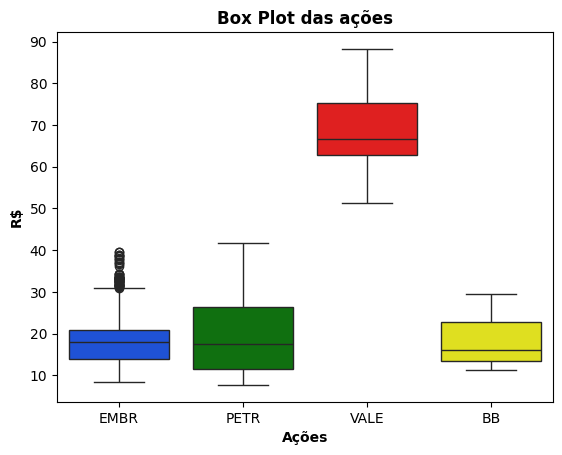

In [88]:
# Criando Box Plot para os papéis
cores=['#0045F5','green','red','yellow']
sns.boxplot(data=df,palette=cores)
plt.title('Box Plot das ações',fontweight='bold')
plt.xlabel('Ações',fontweight='bold')
plt.ylabel('R$',fontweight='bold')
plt.grid(False)
plt.show()

Durante o intervalo de tempo de 2021 até maio de 2024, o gráfico Box Plot e a descrição do df, destacam que a Petrobras e a Vale  tiveram as maiores variações de cotações. Enquanto, os demais tiveram variação mais estáveis e próxima entre si, apesar da Embraer ter tido vários Outliers devido sua alta recente dos preços.  

In [89]:
# Criando gráfico das cotações
figura = px.line(title = 'Histórico de cotações das ações')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df.index, y=df[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

O gráfico demonstra que a Vale ficou "lateralizada" e volátil e as demais é visto uma tendência de crescimento de valor de mercado

In [90]:
# Normalizando as cotações para melhor comparação dos retornos
df_normalizado = df.copy()
for i in df_normalizado.columns[0:]:
  df_normalizado[i] = df_normalizado[i] / df_normalizado[i][0];

In [91]:
# Criando gráfico das cotações normalizadas
figura = px.line(title = 'Histórico de cotações das ações (normalizado)')

for i, coluna in enumerate(df.columns):
    figura.add_scatter(x=df_normalizado.index, y=df_normalizado[coluna], name=coluna, line=dict(color=cores[i]))


figura.update_layout(
    xaxis_title='Data',
    yaxis_title='R$',
    title_x=0.5
)

figura.show()

Após a normalização, fica evidente que a maior valorização dos papéis é da Embraer seguida por Petrobras e Banco do Brasil, enquanto, a Vale teve uma pequena queda.

In [92]:
# Criando uma função para calcular a taxa de retorno simples
def txrs(acao,df):
    df[f'RS {acao}'] = (df[f'{acao}'] / df[f'{acao}'].shift(1)) - 1
    return df

In [93]:
# Aplicando a função para todas colunas
for coluna in df.columns[:len(df)]:
    df_txrs = df.copy()
    df_txrs = txrs(coluna, df)

df_txrs= df_txrs.dropna()

In [94]:
import sys

In [95]:
# Criando função de alocação de Markowitz
def alocacao_markowitz(df, capital, i, n):
  df = df.copy()
  df_original = df.copy()

  ls_txe = []
  ls_vole = []
  ls_sr = []

  melhor_sr = 1 - sys.maxsize
  melhores_p = np.empty
  melhor_vol = 0
  melhor_tx = 0

  for _ in range(n):
    pesos = np.random.random(len(df.columns)-1)
    pesos = pesos / pesos.sum()

    for w in df.columns[1:]:
      df[w] = df[w] / df[w][0]

    for w, k in enumerate(df.columns[1:]):
      df[k] = df[k] * pesos[w] * capital

    df.drop(labels = ['Date'], axis = 1, inplace=True)

    retorno_carteira = np.log(df / df.shift(1))
    matriz_cov = retorno_carteira.cov()

    df['soma valor'] = df.sum(axis = 1)
    df['taxa retorno'] = 0.0

    for w in range(1, len(df)):
      df['taxa retorno'][w] = np.log(df['soma valor'][w] / df['soma valor'][w - 1])

    retorno_esperado = np.sum(df['taxa retorno'].mean() * pesos) * 246
    vol_esperada = np.sqrt(np.dot(pesos, np.dot(matriz_cov * 246, pesos)))
    sharpe_ratio = (retorno_esperado - i) / vol_esperada

    if sharpe_ratio > melhor_sr:
      melhor_sr = sharpe_ratio
      melhores_p = pesos
      melhor_vol = vol_esperada
      melhor_tx = retorno_esperado

    ls_txe.append(retorno_esperado)
    ls_vole.append(vol_esperada)
    ls_sr.append(sharpe_ratio)

    df = df_original.copy()

  return melhor_sr, melhores_p, ls_txe, ls_vole, ls_sr, melhor_vol, melhor_tx

In [96]:
# Pegando DF limpo
teste = pd.read_csv('carteira.csv')

In [101]:
# Rodando a função
import warnings
warnings.filterwarnings("ignore")
melhor_sharpe_ratio, melhores_pesos, lista_retorno_esperado, lista_volatilidade_esperada, lista_sharpe_ratio, melhor_volatilidade, melhor_retorno = alocacao_markowitz(teste, 5000, 10 / 100, 100);

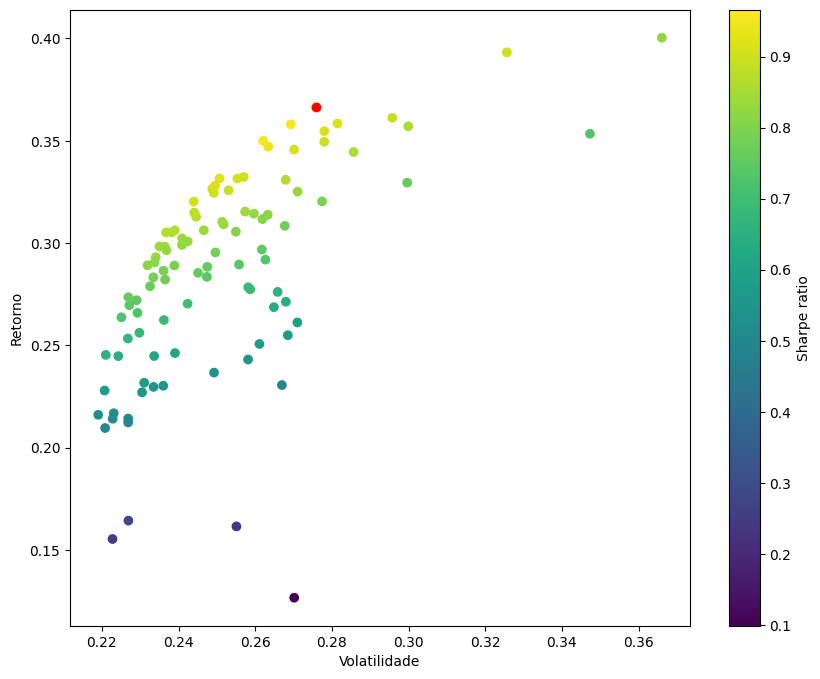

In [102]:
# Gráfico de dispersão
plt.figure(figsize=(10,8))
plt.scatter(lista_volatilidade_esperada, lista_retorno_esperado, c = lista_sharpe_ratio)
plt.colorbar(label = 'Sharpe ratio')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.scatter(melhor_volatilidade, melhor_retorno, c = 'red');

In [103]:
# Biblioteca necessária
#pip install https://github.com/gkhayes/mlrose/archive/refs/heads/master.zip

In [104]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose